Saving Career_Switch_Prediction_Dataset.csv to Career_Switch_Prediction_Dataset.csv
Initial Shape: (5000, 14)
Columns: ['enrollee_id', 'city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours', 'will_change_career']

===== Dataset Description =====
Number of Features: 12
Number of Data Points: 5000
Unique values in target: [1 0]
Quantitative Features: ['city_development_index', 'training_hours', 'will_change_career']
Categorical Features: ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']


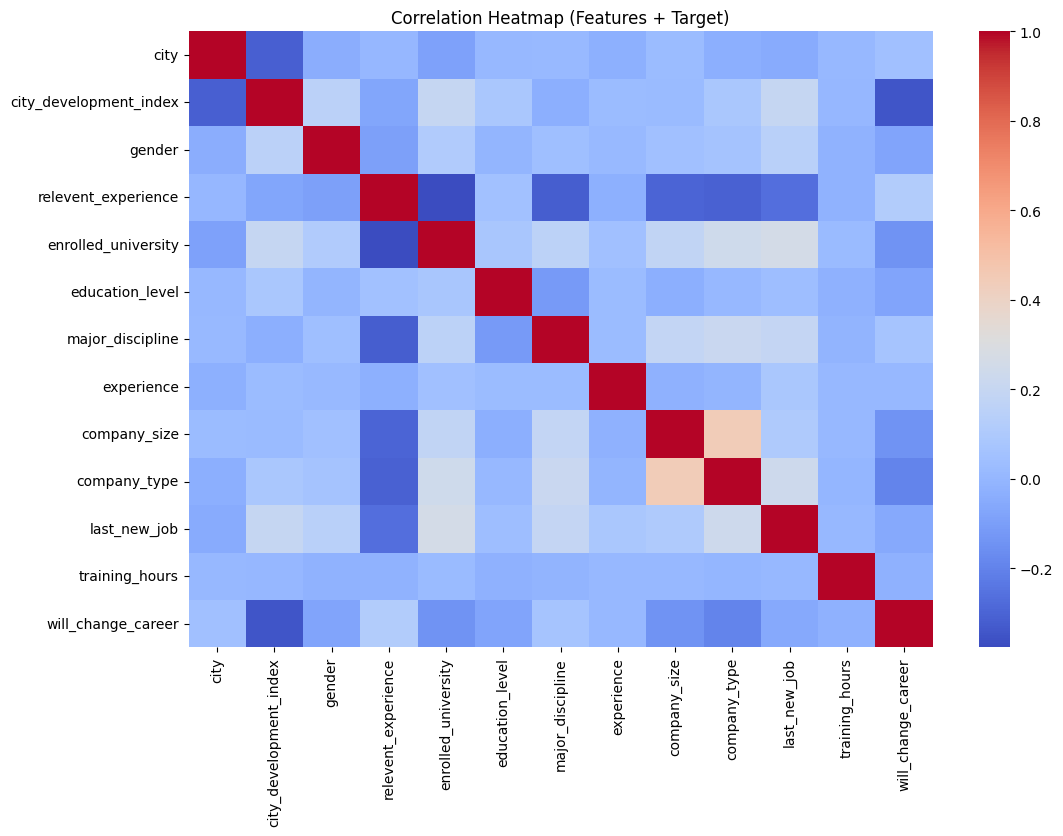


Top correlations with target (absolute):
will_change_career        1.000000
city_development_index    0.346808
company_type              0.197722
enrolled_university       0.144937
company_size              0.140699
relevent_experience       0.112887
gender                    0.080547
education_level           0.076041
Name: will_change_career, dtype: float64


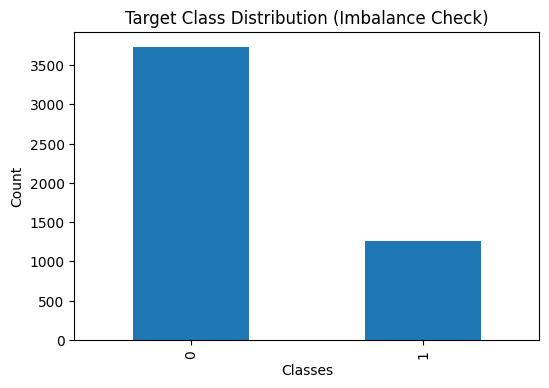

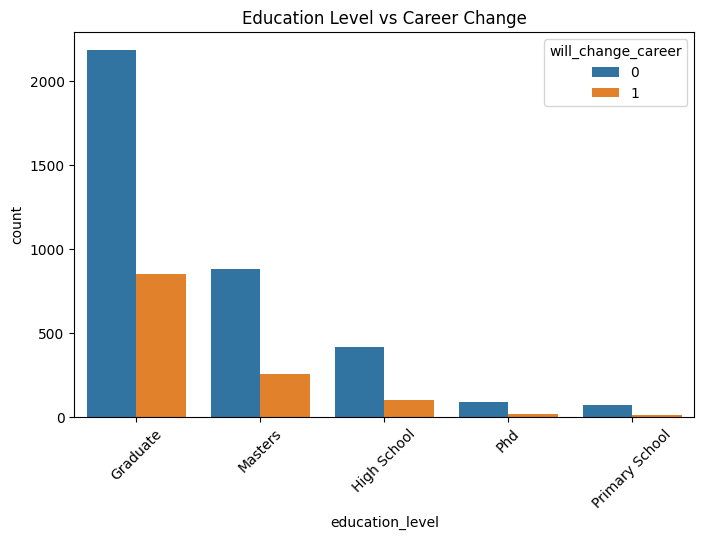

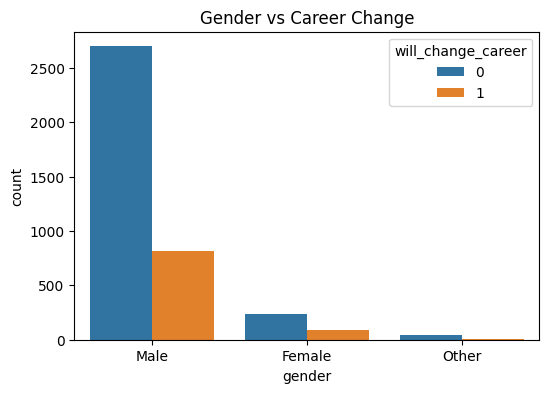

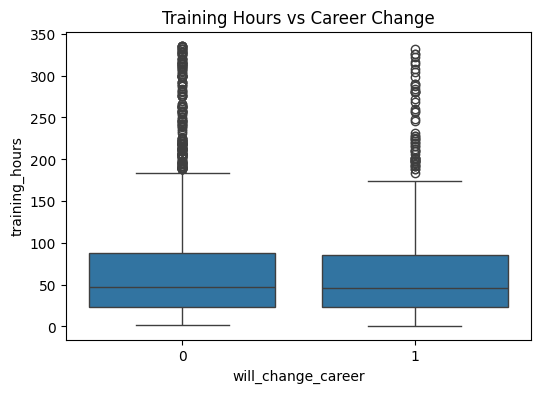

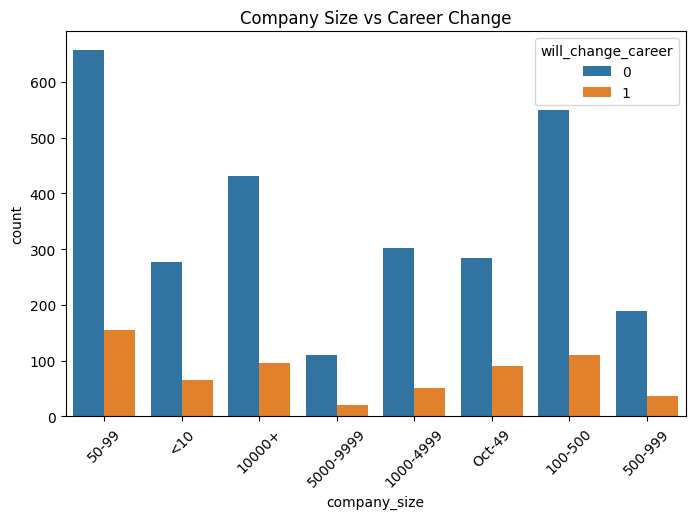


Training set size: 4000
Test set size: 1000

=== Model Performance Summary ===
                    Accuracy Precision    Recall        F1       AUC
Naive Bayes            0.341   0.26474   0.90873  0.410027  0.538574
Neural Network         0.721  0.448276  0.464286   0.45614  0.706169
Logistic Regression     0.72  0.460894  0.654762  0.540984  0.749544


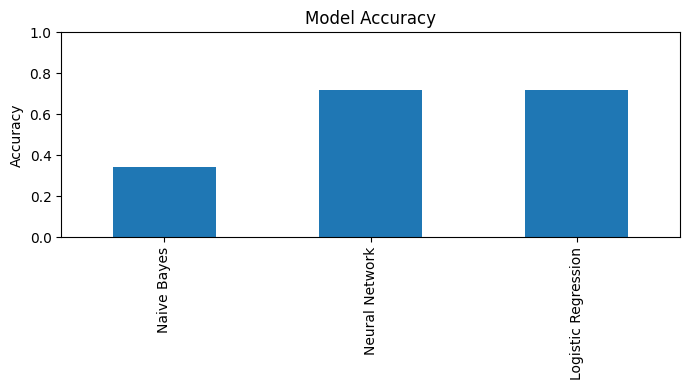

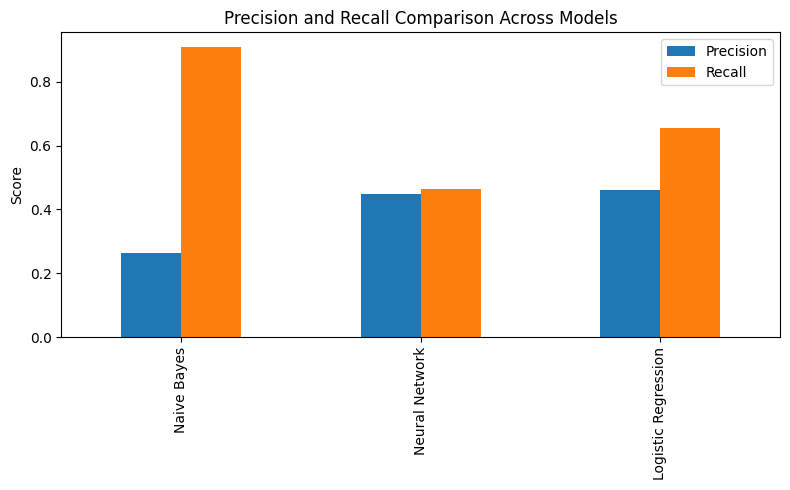

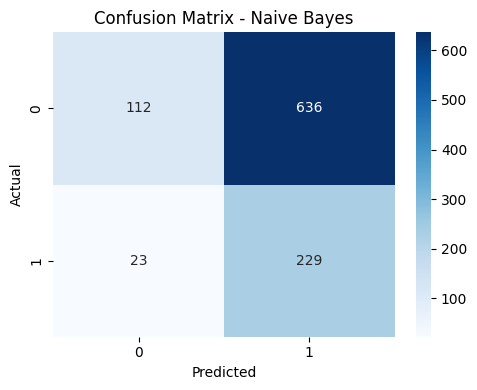

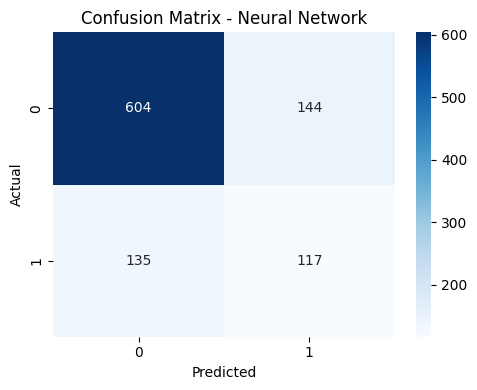

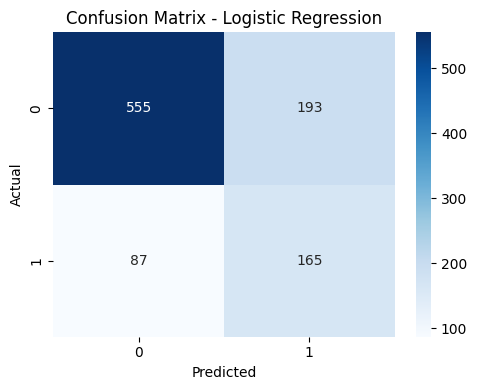

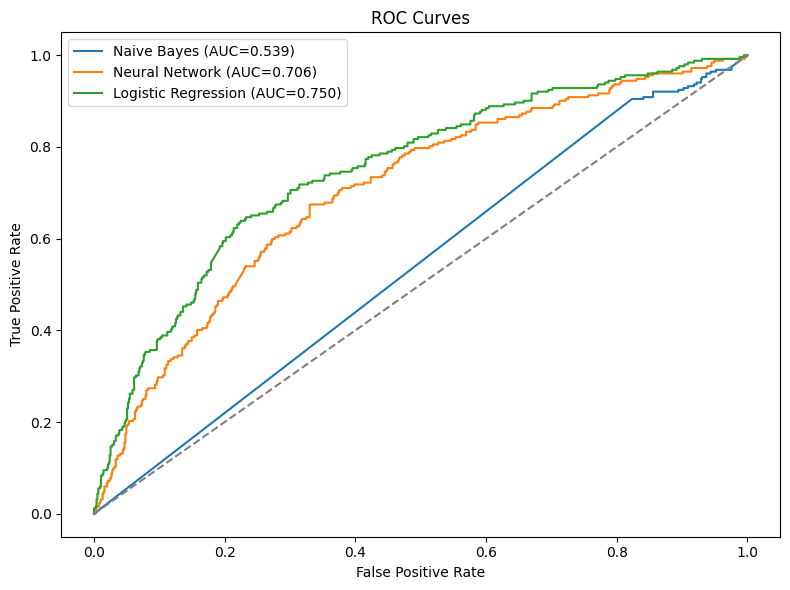

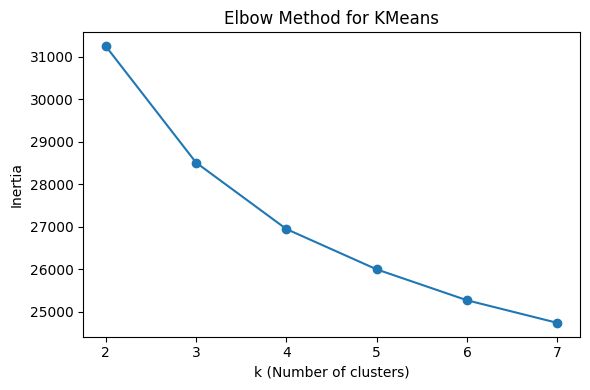


KMeans vs True Labels:
 Cluster       0     1
True Label           
0           743  2995
1           676   586


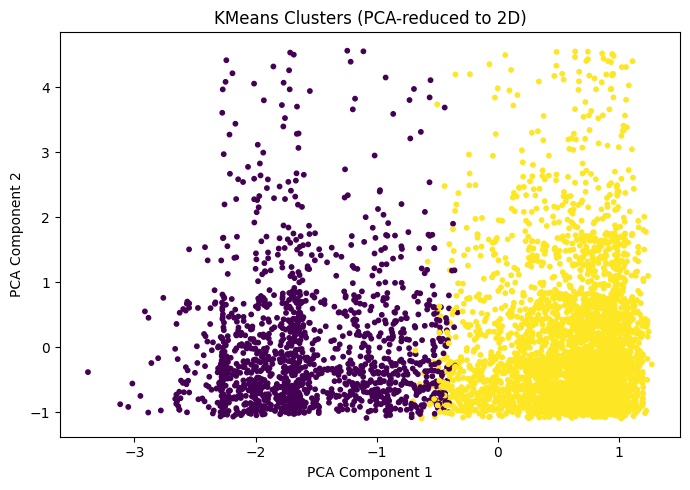

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    classification_report
)

# Unsupervised
from sklearn.cluster import KMeans

# General
RANDOM_STATE = 42

# 1) Load dataset (Colab upload support)
from google.colab import files
uploaded = files.upload()

DATASET = list(uploaded.keys())[0]
df = pd.read_csv(DATASET)

print("Initial Shape:", df.shape)
print("Columns:", list(df.columns))

if "enrollee_id" in df.columns:
    df = df.drop(columns=["enrollee_id"])

target_col = "will_change_career"


# 2) Dataset Description
print("\n===== Dataset Description =====")
print("Number of Features:", df.shape[1] - 1)
print("Number of Data Points:", df.shape[0])
print("Unique values in target:", df[target_col].unique())

quantitative = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
print("Quantitative Features:", quantitative)
print("Categorical Features:", categorical)

# 3) Correlation Matrix + Heatmap
df_corr = df.copy()
for col in categorical:
    df_corr[col] = pd.Categorical(df_corr[col]).codes

corr_matrix = df_corr.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Features + Target)")
plt.show()

print("\nTop correlations with target (absolute):")
print(corr_matrix[target_col].abs().sort_values(ascending=False).head(8))

# 4) Imbalanced Dataset Check
plt.figure(figsize=(6,4))
df[target_col].value_counts().plot(kind="bar")
plt.title("Target Class Distribution (Imbalance Check)")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

# 5) Exploratory Data Analysis (EDA)
plt.figure(figsize=(8,5))
sns.countplot(x="education_level", hue=target_col, data=df)
plt.title("Education Level vs Career Change")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="gender", hue=target_col, data=df)
plt.title("Gender vs Career Change")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=target_col, y="training_hours", data=df)
plt.title("Training Hours vs Career Change")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="company_size", hue=target_col, data=df)
plt.title("Company Size vs Career Change")
plt.xticks(rotation=45)
plt.show()

# 6) Artificial Missing Values + Handling (demo)
df_nan = df.copy()
for col in df_nan.columns:
    if col != target_col:
        df_nan.loc[df_nan.sample(frac=0.02, random_state=RANDOM_STATE).index, col] = np.nan

df_nan = df_nan.dropna(subset=[target_col])

# 7) Preprocessing Setup (with OHE compatibility)
y_raw = df_nan[target_col]
X_raw = df_nan.drop(columns=[target_col])
y = pd.Series(pd.Categorical(y_raw).codes, index=y_raw.index)

numeric_features = X_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_raw.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

import sklearn
from packaging import version
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# 8) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 9) Models (Supervised: Only 3 models)
nb_clf = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", GaussianNB())
])

mlp_clf = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", MLPClassifier(hidden_layer_sizes=(64,32),
                          activation="relu",
                          solver="adam",
                          max_iter=500,
                          random_state=RANDOM_STATE,
                          early_stopping=True))
])

lr_clf = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

classification_models = {
    "Naive Bayes": nb_clf,
    "Neural Network": mlp_clf,
    "Logistic Regression": lr_clf
}

# 10) Training + Evaluation
cls_metrics = {}
probas_for_roc = {}

for name, model in classification_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model.named_steps["clf"], "predict_proba") else y_pred

    cls_metrics[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_proba),
        "ConfusionMatrix": confusion_matrix(y_test, y_pred),
        "Report": classification_report(y_test, y_pred, zero_division=0)
    }
    probas_for_roc[name] = y_proba

metrics_df = pd.DataFrame(cls_metrics).T[["Accuracy", "Precision", "Recall", "F1", "AUC"]]

print("\n=== Model Performance Summary ===")
print(metrics_df)

# 11) Visualizations

metrics_df["Accuracy"].plot(kind="bar", figsize=(7,4))
plt.title("Model Accuracy")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

metrics_df[["Precision","Recall"]].plot(kind="bar", figsize=(8,5))
plt.title("Precision and Recall Comparison Across Models")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

for name in classification_models:
    cm = cls_metrics[name]["ConfusionMatrix"]
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

plt.figure(figsize=(8,6))
for name in classification_models:
    fpr, tpr, _ = roc_curve(y_test, probas_for_roc[name])
    plt.plot(fpr, tpr, label=f"{name} (AUC={cls_metrics[name]['AUC']:.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# 12) Unsupervised: KMeans

X_pre = preprocessor.fit_transform(X_raw)

inertia = []
for k in range(2,8):
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    km.fit(X_pre)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,8), inertia, marker="o")
plt.title("Elbow Method for KMeans")
plt.xlabel("k (Number of clusters)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=2, n_init=10, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_pre)

ct = pd.crosstab(pd.Series(y, name="True Label"), pd.Series(clusters, name="Cluster"))
print("\nKMeans vs True Labels:\n", ct)

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_pre)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="viridis", s=10)
plt.title("KMeans Clusters (PCA-reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()
